# Spring 2022
# CPSC 585 Project 5
## Raymond Carpio
## Yu Pan
## Sijie Shang
## John Tu

# 1. Begin with the Keras example Collaborative Filtering for Movie Recommendations and verify that you can obtain the sample examples.
## This example uses the Keras Embedding layer type. While it may not be clear from the documentation, this layer type can be used to build an autoencoder. For example, to build the basic autoencoder of Figure 2.7 on p. 73 of the textbook, you could stack together an Embedding layer with input_dim 5 and output_dim 3 with another Embedding layer with input_dim 3 and output_dim 5.
## While this could obviously be done instead using a single Dense hidden layer, the difference is that Embedding layers work well with sparse data (e.g. where users have not rated most movies in the dataset.)
## As a result, the model corresponds roughly to the matrix factorization shown in Figure 2.13 on p. 84 of the textbook, using the dot product to compute the similarity of the user and movie vectors.

In [1]:
import pandas as pd
import numpy as np
from zipfile import ZipFile
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from pathlib import Path
import matplotlib.pyplot as plt

In [2]:
# Download the actual data from http://files.grouplens.org/datasets/movielens/ml-latest-small.zip"
# Use the ratings.csv file
movielens_data_file_url = (
    "http://files.grouplens.org/datasets/movielens/ml-latest-small.zip"
)
movielens_zipped_file = keras.utils.get_file(
    "ml-latest-small.zip", movielens_data_file_url, extract=False
)
keras_datasets_path = Path(movielens_zipped_file).parents[0]
movielens_dir = keras_datasets_path / "ml-latest-small"

# Only extract the data the first time the script is run.
if not movielens_dir.exists():
    with ZipFile(movielens_zipped_file, "r") as zip:
        # Extract files
        print("Extracting all the files now...")
        zip.extractall(path=keras_datasets_path)
        print("Done!")

ratings_file = movielens_dir / "ratings.csv"
df = pd.read_csv(ratings_file)

In [3]:
user_ids = df["userId"].unique().tolist()
user2user_encoded = {x: i for i, x in enumerate(user_ids)}
userencoded2user = {i: x for i, x in enumerate(user_ids)}
movie_ids = df["movieId"].unique().tolist()
movie2movie_encoded = {x: i for i, x in enumerate(movie_ids)}
movie_encoded2movie = {i: x for i, x in enumerate(movie_ids)}
df["user"] = df["userId"].map(user2user_encoded)
df["movie"] = df["movieId"].map(movie2movie_encoded)

num_users = len(user2user_encoded)
num_movies = len(movie_encoded2movie)
df["rating"] = df["rating"].values.astype(np.float32)
# min and max ratings will be used to normalize the ratings later
min_rating = min(df["rating"])
max_rating = max(df["rating"])

print(
    "Number of users: {}, Number of Movies: {}, Min rating: {}, Max rating: {}".format(
        num_users, num_movies, min_rating, max_rating
    )
)

Number of users: 610, Number of Movies: 9724, Min rating: 0.5, Max rating: 5.0


In [4]:
df = df.sample(frac=1, random_state=42)
x = df[["user", "movie"]].values
# Normalize the targets between 0 and 1. Makes it easy to train.
y = df["rating"].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values
# Assuming training on 90% of the data and validating on 10%.
train_indices = int(0.9 * df.shape[0])
x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:],
)

In [5]:
EMBEDDING_SIZE = 50


class RecommenderNet(keras.Model):
    def __init__(self, num_users, num_movies, embedding_size, **kwargs):
        super(RecommenderNet, self).__init__(**kwargs)
        self.num_users = num_users
        self.num_movies = num_movies
        self.embedding_size = embedding_size
        self.user_embedding = layers.Embedding(
            num_users,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.user_bias = layers.Embedding(num_users, 1)
        self.movie_embedding = layers.Embedding(
            num_movies,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.movie_bias = layers.Embedding(num_movies, 1)

    def call(self, inputs):
        user_vector = self.user_embedding(inputs[:, 0])
        user_bias = self.user_bias(inputs[:, 0])
        movie_vector = self.movie_embedding(inputs[:, 1])
        movie_bias = self.movie_bias(inputs[:, 1])
        dot_user_movie = tf.tensordot(user_vector, movie_vector, 2)
        # Add all the components (including bias)
        x = dot_user_movie + user_bias + movie_bias
        # The sigmoid activation forces the rating to between 0 and 1
        return tf.nn.sigmoid(x)


model = RecommenderNet(num_users, num_movies, EMBEDDING_SIZE)
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(), optimizer=keras.optimizers.Adam(lr=0.001)
)

C:\ProgramData\Anaconda3\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [6]:
history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=64,
    epochs=5,
    verbose=1,
    validation_data=(x_val, y_val),
)

Epoch 1/5
1418/1418 [==============================] - 10s 7ms/step - loss: 0.6366 - val_loss: 0.6214
Epoch 2/5
1418/1418 [==============================] - 9s 6ms/step - loss: 0.6133 - val_loss: 0.6181
Epoch 3/5
1418/1418 [==============================] - 9s 6ms/step - loss: 0.6083 - val_loss: 0.6143
Epoch 4/5
1418/1418 [==============================] - 9s 6ms/step - loss: 0.6068 - val_loss: 0.6145
Epoch 5/5
1418/1418 [==============================] - 10s 7ms/step - loss: 0.6064 - val_loss: 0.6132


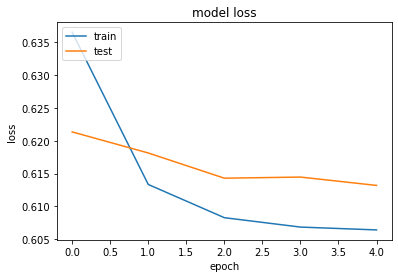

In [7]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()

In [8]:
movie_df = pd.read_csv(movielens_dir / "movies.csv")

# Let us get a user and see the top recommendations.
user_id = df.userId.sample(1).iloc[0]
movies_watched_by_user = df[df.userId == user_id]
#print(movies_watched_by_user)

def recommender_1(movies_watched_by_user):
    movies_not_watched = movie_df[
        ~movie_df["movieId"].isin(movies_watched_by_user.movieId.values)
    ]["movieId"]
    movies_not_watched = list(
        set(movies_not_watched).intersection(set(movie2movie_encoded.keys()))
    )
    movies_not_watched = [[movie2movie_encoded.get(x)] for x in movies_not_watched]

    user_encoder = user2user_encoded.get(user_id)
    user_movie_array = np.hstack(
        ([[user_encoder]] * len(movies_not_watched), movies_not_watched)
    )
    ratings = model.predict(user_movie_array).flatten()
    top_ratings_indices = ratings.argsort()[-10:][::-1]
    recommended_movie_ids = [
        movie_encoded2movie.get(movies_not_watched[x][0]) for x in top_ratings_indices
    ]

    print("Showing recommendations for user: {}".format(user_id))
    print("====" * 9)
    print("Movies with high ratings from user")
    print("----" * 8)
    top_movies_user = (
        movies_watched_by_user.sort_values(by="rating", ascending=False)
        .head(5)
        .movieId.values
    )
    movie_df_rows = movie_df[movie_df["movieId"].isin(top_movies_user)]
    for row in movie_df_rows.itertuples():
        print(row.title, ":", row.genres)

    print("----" * 8)
    print("Top 10 movie recommendations")
    print("----" * 8)
    recommended_movies = movie_df[movie_df["movieId"].isin(recommended_movie_ids)]
    for row in recommended_movies.itertuples():
        print(row.title, ":", row.genres)
recommender_1(movies_watched_by_user)

Showing recommendations for user: 356
Movies with high ratings from user
--------------------------------
Casablanca (1942) : Drama|Romance
Empire Records (1995) : Comedy|Drama
Sandlot, The (1993) : Children|Comedy|Drama
Hours, The (2002) : Drama|Romance
Dark Knight, The (2008) : Action|Crime|Drama|IMAX
--------------------------------
Top 10 movie recommendations
--------------------------------
Rear Window (1954) : Mystery|Thriller
Goodfellas (1990) : Crime|Drama
Cool Hand Luke (1967) : Drama
Omen, The (1976) : Horror|Mystery|Thriller
Star Trek: First Contact (1996) : Action|Adventure|Sci-Fi|Thriller
Shine (1996) : Drama|Romance
American History X (1998) : Crime|Drama
Boondock Saints, The (2000) : Action|Crime|Drama|Thriller
Outlaw Josey Wales, The (1976) : Action|Adventure|Drama|Thriller|Western
Strada, La (1954) : Drama


# 2. Construct a feature vector for one or move members of your team, choosing and rating several movies that they have seen. (Do not rate all movies that they have seen — leave room for recommendations.)
# What other movies does the network recommend? How many of the recommended movies have they actually seen? Were the recommendations accurate?

In [9]:
rated_movies = {'userId': [999,999,999,999,999,999,999,999,999,999], 'movieId': [1,3114,8368,40815,40629,176101,135536,129779,122924,122912], 'rating': [4,4,4,4,5,4,3,3.5,4,5]}
movies_watched_by_user = pd.DataFrame(rated_movies)
recommender_1(movies_watched_by_user)

Showing recommendations for user: 356
Movies with high ratings from user
--------------------------------
Toy Story (1995) : Adventure|Animation|Children|Comedy|Fantasy
Toy Story 2 (1999) : Adventure|Animation|Children|Comedy|Fantasy
Harry Potter and the Prisoner of Azkaban (2004) : Adventure|Fantasy|IMAX
Pride & Prejudice (2005) : Drama|Romance
Avengers: Infinity War - Part I (2018) : Action|Adventure|Sci-Fi
--------------------------------
Top 10 movie recommendations
--------------------------------
Shawshank Redemption, The (1994) : Crime|Drama
Forrest Gump (1994) : Comedy|Drama|Romance|War
Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1964) : Comedy|War
Matrix, The (1999) : Action|Sci-Fi|Thriller
Fight Club (1999) : Action|Crime|Drama|Thriller
Boondock Saints, The (2000) : Action|Crime|Drama|Thriller
Lord of the Rings: The Fellowship of the Ring, The (2001) : Adventure|Fantasy
Lord of the Rings: The Return of the King, The (2003) : Action|Adventure|Drama|Fa

## A: The movies that the system recommends based on watch history are listed above in the Top 10 movie recommendations list. Based on the genres listed from the recommendations list, the only genres that are relevant based on user's watch history are Comedy, Action, and Adventure. Thus, the recommendations are not somewhat accurate.

# 3. While the matrix factorization model described in the textbook relies on only a single dense hidden layer (or equivalently, two hidden embedding layers), it should be possible to achieve better results with a deeper network.
# Replace the dot product with one or more dense layers, allowing the network to learn relationships between the user and movie vectors. Compare the performance of the network on the training and validation sets.

In [10]:
# Instead of modifying the existing model from Problem 1, build a new model with a Dense hidden layer.
model2 = tf.keras.Sequential()
model2.add(tf.keras.Input(shape=(2,)))
model2.add(tf.keras.layers.Dense(200, activation="relu", name="HiddenLayer"))
model2.add(tf.keras.layers.Flatten())
model2.add(tf.keras.layers.Dense(1, activation="sigmoid", name="OutputLayer"))

model2.summary()
model2.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=keras.optimizers.Adam(lr=0.001))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 HiddenLayer (Dense)         (None, 200)               600       
                                                                 
 flatten (Flatten)           (None, 200)               0         
                                                                 
 OutputLayer (Dense)         (None, 1)                 201       
                                                                 
Total params: 801
Trainable params: 801
Non-trainable params: 0
_________________________________________________________________


In [11]:
history = model2.fit(
    x=x_train,
    y=y_train,
    batch_size=64,
    epochs=5,
    verbose=1,
    validation_data=(x_val, y_val),
)

Epoch 1/5
1418/1418 [==============================] - 2s 929us/step - loss: 1.4455 - val_loss: 1.7093
Epoch 2/5
1418/1418 [==============================] - 1s 1ms/step - loss: 1.1905 - val_loss: 1.0352
Epoch 3/5
1418/1418 [==============================] - 2s 2ms/step - loss: 1.2394 - val_loss: 0.7234
Epoch 4/5
1418/1418 [==============================] - 2s 1ms/step - loss: 1.1899 - val_loss: 0.6444
Epoch 5/5
1418/1418 [==============================] - 2s 1ms/step - loss: 1.1021 - val_loss: 1.1108


In [12]:
# Follow the same procedure from Problem 1, except try a different user id.
user_id = df.userId.sample(1).iloc[0]
movies_watched_by_user = df[df.userId == user_id]
#print(movies_watched_by_user)

def recommender_2(movies_watched_by_user):
    movies_not_watched = movie_df[
        ~movie_df["movieId"].isin(movies_watched_by_user.movieId.values)
    ]["movieId"]
    movies_not_watched = list(
        set(movies_not_watched).intersection(set(movie2movie_encoded.keys()))
    )
    movies_not_watched = [[movie2movie_encoded.get(x)] for x in movies_not_watched]

    user_encoder = user2user_encoded.get(user_id)
    user_movie_array = np.hstack(
        ([[user_encoder]] * len(movies_not_watched), movies_not_watched)
    )
    ratings = model2.predict(user_movie_array).flatten()
    top_ratings_indices = ratings.argsort()[-10:][::-1]
    recommended_movie_ids = [
        movie_encoded2movie.get(movies_not_watched[x][0]) for x in top_ratings_indices
    ]

    print("Showing recommendations for user: {}".format(user_id))
    print("====" * 9)
    print("Movies with high ratings from user")
    print("----" * 8)
    top_movies_user = (
        movies_watched_by_user.sort_values(by="rating", ascending=False)
        .head(5)
        .movieId.values
    )
    movie_df_rows = movie_df[movie_df["movieId"].isin(top_movies_user)]
    for row in movie_df_rows.itertuples():
        print(row.title, ":", row.genres)

    print("----" * 8)
    print("Top 10 movie recommendations")
    print("----" * 8)
    recommended_movies = movie_df[movie_df["movieId"].isin(recommended_movie_ids)]
    for row in recommended_movies.itertuples():
        print(row.title, ":", row.genres)
recommender_2(movies_watched_by_user)

Showing recommendations for user: 318
Movies with high ratings from user
--------------------------------
Marat/Sade (1966) : Drama|Musical
Woman Under the Influence, A (1974) : Drama
Fast Food Nation (2006) : Drama
Django Unchained (2012) : Action|Drama|Western
Interstellar (2014) : Sci-Fi|IMAX
--------------------------------
Top 10 movie recommendations
--------------------------------
Very Bad Things (1998) : Comedy|Crime
Psycho (1998) : Crime|Horror|Thriller
Romancing the Stone (1984) : Action|Adventure|Comedy|Romance
Young Sherlock Holmes (1985) : Action|Adventure|Children|Fantasy|Mystery|Thriller
Howard the Duck (1986) : Adventure|Comedy|Sci-Fi
Texas Chainsaw Massacre, The (1974) : Horror
Crocodile Dundee (1986) : Adventure|Comedy
¡Three Amigos! (1986) : Comedy|Western
20 Dates (1998) : Comedy|Romance
SLC Punk! (1998) : Comedy|Drama


In [13]:
# This snippet of code is imported from problem 2, and will be used to compare results for problem 3.
rated_movies = {'userId': [999,999,999,999,999,999,999,999,999,999], 'movieId': [1,3114,8368,40815,40629,176101,135536,129779,122924,122912], 'rating': [4,4,4,4,5,4,3,3.5,4,5]}
movies_watched_by_user = pd.DataFrame(rated_movies)
recommender_2(movies_watched_by_user)

Showing recommendations for user: 318
Movies with high ratings from user
--------------------------------
Toy Story (1995) : Adventure|Animation|Children|Comedy|Fantasy
Toy Story 2 (1999) : Adventure|Animation|Children|Comedy|Fantasy
Harry Potter and the Prisoner of Azkaban (2004) : Adventure|Fantasy|IMAX
Pride & Prejudice (2005) : Drama|Romance
Avengers: Infinity War - Part I (2018) : Action|Adventure|Sci-Fi
--------------------------------
Top 10 movie recommendations
--------------------------------
Thin Red Line, The (1998) : Action|Drama|War
Howard the Duck (1986) : Adventure|Comedy|Sci-Fi
Texas Chainsaw Massacre, The (1974) : Horror
Crocodile Dundee (1986) : Adventure|Comedy
¡Three Amigos! (1986) : Comedy|Western
20 Dates (1998) : Comedy|Romance
Office Space (1999) : Comedy|Crime
Logan's Run (1976) : Action|Adventure|Sci-Fi
Planet of the Apes (1968) : Action|Drama|Sci-Fi
Lock, Stock & Two Smoking Barrels (1998) : Comedy|Crime|Thriller


# 4. Compare the quality of the recommendations from experiment (2) with those of the new network of experiment (3). Does the recommendation performance improve for the members of your team?

## A: The recommendations from experiment 2 shows Drama movies as the top 10 recommedations, and for the user, 8 movies watched by the user is Drama. For experiment 3, two recommendation models are created by using the Dense layer network, and there are some issues regarding about the performance. For the first one, the movies that the user watched are Action movies, while the second one contains watched movies with Adventure and Fantasy genres as the most common. The top 10 recommendations for both models contain Thriller as the most recurring genre, in which although this can be said true for the 3 movies that the user has watched, none of those can be applied to the movies that the user has watched for the second model. Thus, the recommendation performance has not yet improved.

# 5. If you were disappointed by the results of experiments (3) and (4), your network may be suffering from the problem shown in Figure 2.11 on p. 79 of the textbook, where the hidden layers do a poor job mapping out-of-sample data points to reduced representations. This is exactly the problem addressed by variational autoencoders.
# Use the Keras example Variational AutoEncoder to add an additional sampling layer to your network.
## Note: although much of the code is specific to building a convolutional VAE, you will also need to customize the training process as shown in the example in order to implement the loss function of Equations 4.17 through 4.19 on p. 208 of the textbook.
# Compare the performance of this network with those in experiments (1) and (3).

In [14]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [15]:
latent_dim = 2
# Instead of modifying the existing model from Problem 1, build a new model with a Dense hidden layer.
encoder_inputs = keras.Input(shape=(50, 610, 1))
#encoder.add(tf.keras.Input(shape=(2,)))
x = tf.keras.layers.Dense(200, activation="relu", name="HiddenLayer")(encoder_inputs)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(1, activation="sigmoid", name="OutputLayer")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()
#encoder.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=keras.optimizers.Adam(lr=0.001))

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 50, 610, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 HiddenLayer (Dense)            (None, 50, 610, 200  400         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 flatten_1 (Flatten)            (None, 6100000)      0           ['HiddenLayer[0][0]']            
                                                                                            

In [16]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(50 *610 *200, activation="sigmoid")(latent_inputs)
x = layers.Reshape((50, 610, 200))(x)
decoder_outputs = tf.keras.layers.Dense(200, activation="relu", name="OutputLayer")(x)
#decoder_outputs = layers.Dense(1, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense (Dense)               (None, 6100000)           18300000  
                                                                 
 reshape (Reshape)           (None, 50, 610, 200)      0         
                                                                 
 OutputLayer (Dense)         (None, 50, 610, 200)      40200     
                                                                 
Total params: 18,340,200
Trainable params: 18,340,200
Non-trainable params: 0
_________________________________________________________________


In [17]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

In [21]:
print(x_train.shape)
print(y_train.shape)

(90752, 2)
(90752,)


In [21]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(x=x_train, y=y_train, epochs=30, batch_size=128,validation_data=(x_val, y_val))

Epoch 1/30


ValueError: in user code:

    File "C:\ProgramData\Anaconda3\lib\site-packages\keras\engine\training.py", line 1021, in train_function  *
        return step_function(self, iterator)
    File "C:\ProgramData\Anaconda3\lib\site-packages\keras\engine\training.py", line 1010, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\ProgramData\Anaconda3\lib\site-packages\keras\engine\training.py", line 1000, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\johnt\AppData\Local\Temp/ipykernel_9396/3236315084.py", line 22, in train_step
        z_mean, z_log_var, z = self.encoder(data)
    File "C:\ProgramData\Anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\ProgramData\Anaconda3\lib\site-packages\keras\engine\input_spec.py", line 200, in assert_input_compatibility
        raise ValueError(f'Layer "{layer_name}" expects {len(input_spec)} input(s),'

    ValueError: Layer "encoder" expects 1 input(s), but it received 2 input tensors. Inputs received: [<tf.Tensor 'IteratorGetNext:0' shape=(128, 2) dtype=int64>, <tf.Tensor 'IteratorGetNext:1' shape=(128,) dtype=float32>]


In [ ]:
user_id = df.userId.sample(1).iloc[0]
movies_watched_by_user = df[df.userId == user_id]
#print(movies_watched_by_user)

def recommender_3(movies_watched_by_user):
    movies_not_watched = movie_df[
        ~movie_df["movieId"].isin(movies_watched_by_user.movieId.values)
    ]["movieId"]
    movies_not_watched = list(
        set(movies_not_watched).intersection(set(movie2movie_encoded.keys()))
    )
    movies_not_watched = [[movie2movie_encoded.get(x)] for x in movies_not_watched]

    user_encoder = user2user_encoded.get(user_id)
    user_movie_array = np.hstack(
        ([[user_encoder]] * len(movies_not_watched), movies_not_watched)
    )
    ratings = vae.predict(user_movie_array).flatten()
    top_ratings_indices = ratings.argsort()[-10:][::-1]
    recommended_movie_ids = [
        movie_encoded2movie.get(movies_not_watched[x][0]) for x in top_ratings_indices
    ]

    print("Showing recommendations for user: {}".format(user_id))
    print("====" * 9)
    print("Movies with high ratings from user")
    print("----" * 8)
    top_movies_user = (
        movies_watched_by_user.sort_values(by="rating", ascending=False)
        .head(5)
        .movieId.values
    )
    movie_df_rows = movie_df[movie_df["movieId"].isin(top_movies_user)]
    for row in movie_df_rows.itertuples():
        print(row.title, ":", row.genres)

    print("----" * 8)
    print("Top 10 movie recommendations")
    print("----" * 8)
    recommended_movies = movie_df[movie_df["movieId"].isin(recommended_movie_ids)]
    for row in recommended_movies.itertuples():
        print(row.title, ":", row.genres)
recommender_3(movies_watched_by_user)

In [ ]:
rated_movies = {'userId': [999,999,999,999,999,999,999,999,999,999], 'movieId': [1,3114,8368,40815,40629,176101,135536,129779,122924,122912], 'rating': [4,4,4,4,5,4,3,3.5,4,5]}
movies_watched_by_user = pd.DataFrame(rated_movies)
recommender_3(movies_watched_by_user)